In [30]:
%matplotlib notebook
import numpy
import scipy
import scipy.interpolate

import copy
import os.path

import cPickle as pkl

import matplotlib.colors as colors

In [2]:
import multiprocessing

In [3]:
import matplotlib.pyplot as plot

In [4]:
filename = 'grs1915_all_125ms.dat'

In [5]:
data_original = numpy.load(filename)
data = data_original

In [6]:
n_samples = len(data)
print '# of samples:', n_samples

# of samples: 2829


In [7]:
labelled = [dd[1] is not None for dd in data]
print '# of labelled samples:', numpy.sum(labelled)

# of labelled samples: 426


There are many missing values in the observation, which are marked as NaN. For this notebook, we simply replace those NaN's by a simple linear interpolation.

In [8]:
def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    inds = numpy.arange(A.shape[0])
    good = numpy.where(numpy.isfinite(A))
    f = scipy.interpolate.interp1d(inds[good], A[good],bounds_error=False, fill_value='extrapolate')
    B = numpy.where(numpy.isfinite(A),A,f(inds))
    return B

In [9]:
# replace NaN with 0's for now.
data_original = copy.deepcopy(data)
data = [None] * n_samples
for idx, dd in enumerate(data_original):
    x = dd[0]
    if x.shape[0] > 2:
        y = 0. * x
        for ii in xrange(x.shape[1]):
            y[:, ii] = fill_nan(x[:,ii])
        if numpy.sum(numpy.isnan(y)) > 0:
            print 'problem at ', idx
            break
    else:
        y = x
    data[idx] = (y, dd[1])

/Users/kyunghyuncho/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in multiply


Okay, now this is a tricky part. I want to normalize the time series, but what is the correct way to do so? For now, I'm simply normalizing each time series separately to be zero-mean and unit-variance.

In [10]:
# simple normalization
data_n = [None] * n_samples
for idx, dd in enumerate(data):
    m = dd[0].mean(axis=0)
    s = dd[0].std(axis=0)
    dn = (dd[0] - m)/numpy.max(s, 1e-8)
    data_n[idx] = (dn, dd[1])

/Users/kyunghyuncho/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


<IPython.core.display.Javascript object>


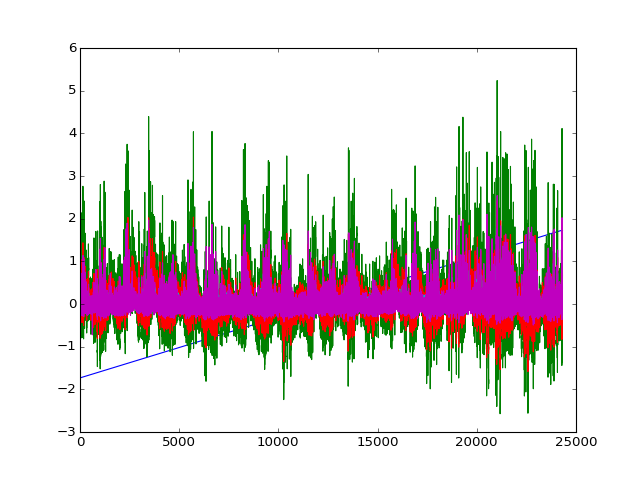

In [11]:
idx = 10

plot.hold('on')
for varidx in xrange(data_n[idx][0].shape[1]):
    plot.plot(data_n[idx][0][:,varidx])
plot.hold('off')
plot.show()

Well, it's a time series with varying number of steps. Let's try Fourier transform to convert each timeseries into a fixed-length representation here.

In [12]:
def do_fft(dd):
    fftc = numpy.fft.fft(dd[0], axis=0)
    return (fftc, dd[1])

In [13]:
if os.path.exists(filename+'.fft.npy'):
    fft_coeffs = numpy.load(filename+'.fft.npy')
else:
    pool = multiprocessing.Pool(6)
    fft_coeffs = pool.map(do_fft, data)
    numpy.save(filename+'.fft', fft_coeffs)

In [14]:
band_max=1000

<IPython.core.display.Javascript object>


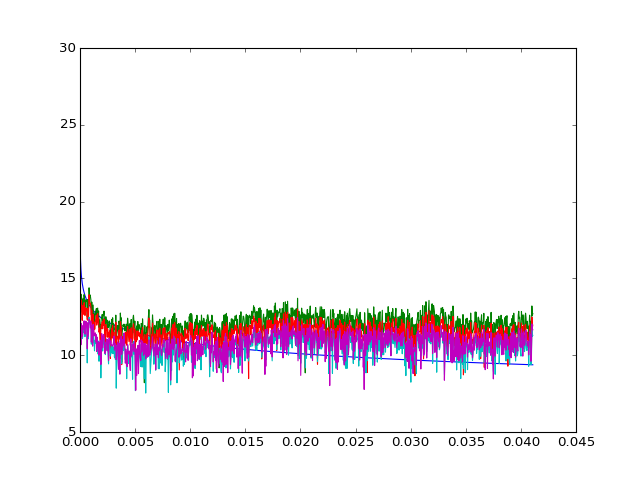

In [15]:
idx = 10

plot.figure()
plot.hold('on')
for varidx in xrange(fft_coeffs[idx][0].shape[1]):
    ll = fft_coeffs[idx][0].shape[0]
    coeff = fft_coeffs[idx][0][:,varidx]
    freq = numpy.fft.fftfreq(len(coeff))
    plot.plot(freq[:band_max], numpy.log(numpy.absolute(coeff[:band_max])))
plot.hold('off')
plot.show()

In [16]:
fft_coeffs_filt = [(numpy.absolute(dd[0][:band_max,:]), dd[1]) for dd in fft_coeffs]
for idx, dd in enumerate(fft_coeffs_filt):
    if numpy.sum(numpy.isnan(dd[0])) > 0:
        print 'NaN detected at', idx
        break
    dd[0].resize(band_max, dd[0].shape[1])

In [17]:
fft_features = numpy.vstack([dd[0].flatten() for dd in fft_coeffs_filt])

Let's project the FFT-based features down to 2-D using PCA+tSNE.

In [18]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=50)
Y_pca = pca_model.fit_transform(fft_features)

In [ ]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
Y_tsne = model.fit_transform(Y_pca)

In [19]:
labels = numpy.unique([dd[1] for dd in data_original])
label_dict = dict([(dd,ii) for ii, dd in enumerate(labels)])

<IPython.core.display.Javascript object>


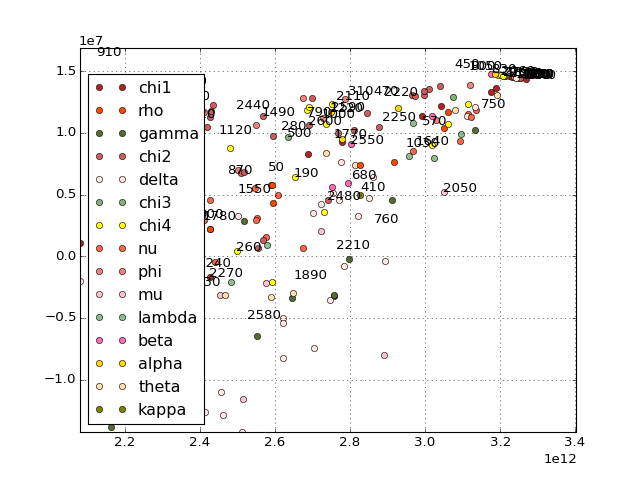

In [21]:
plot.figure()
clist = colors.cnames.values()

Y = Y_pca
legends = []
legend_handles = []
leg_check = dict()
plot.hold('on')

every=10
for idx in xrange(Y.shape[0]):
    if data_original[idx][1] is None:
        #plot.plot(Y[idx,0], Y[idx,1], 'kx')
        pass
    else:
        f, = plot.plot(Y[idx,0], Y[idx,1], 'o', color=clist[label_dict[data_original[idx][1]]])
        if data_original[idx][1] not in leg_check:
            legends.append(data_original[idx][1])
            legend_handles.append(f)
            leg_check[data_original[idx][1]] = True
    if numpy.mod(idx, every) == 0:
        plot.annotate(xy=(Y[idx,0], Y[idx,1]), s=idx)

plot.hold('off')
plot.legend(legend_handles, legends, loc="lower left")
plot.grid('on')

plot.show()

If there are any interesting timeseries found from the figure above, let's draw them here.

<IPython.core.display.Javascript object>


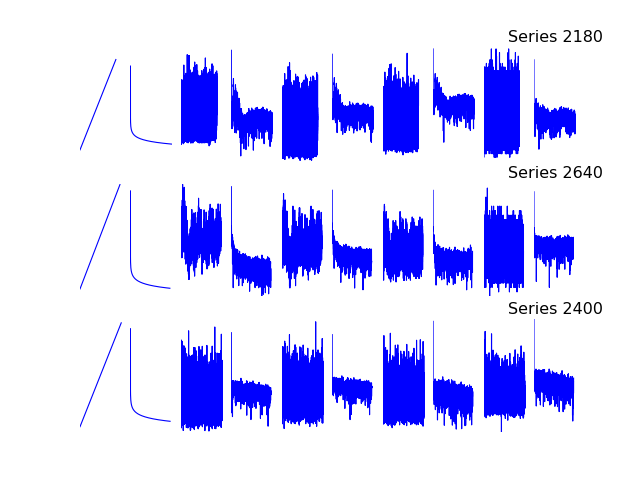

In [25]:
interesting = [2180, 2640, 2400]
band_max=1000

plot.figure()
for idx, ii in enumerate(interesting):
    series = data_original[ii][0]
    for sidx in xrange(series.shape[1]):
        plot.subplot(len(interesting), 5*2, idx*(5*2)+(2*sidx)+1)
        plot.plot(series[:,sidx])
        plot.axis('off')
        
        plot.subplot(len(interesting), 5*2, idx*(5*2)+(2*sidx)+2)
        ll = fft_coeffs[ii][0].shape[0]
        coeff = fft_coeffs[ii][0][:,sidx]
        freq = numpy.fft.fftfreq(len(coeff))
        plot.plot(freq[:band_max], numpy.log(numpy.absolute(coeff[:band_max])))
        plot.axis('off')
    plot.title('Series %d'%ii)


Let's try a deep autoencoder. We'll work on the PCA'd fourier features. We're using Theano, so install theano by ``pip install --user theano``

In [22]:
import theano
from theano import tensor
from theano.sandbox.rng_mrg import MRG_RandomStreams

from collections import OrderedDict

In [23]:
def rmsprop(tparams, grads, inps, cost):
    zipped_grads = [theano.shared(p.get_value() * numpy.float32(0.), 
                                  name='%s_grad'%k) 
                    for k, p in tparams.iteritems()]
    running_grads = [theano.shared(p.get_value() * numpy.float32(0.), 
                                   name='%s_rgrad'%k) 
                     for k, p in tparams.iteritems()]
    running_grads2 = [theano.shared(p.get_value() * numpy.float32(0.), 
                                    name='%s_rgrad2'%k) 
                      for k, p in tparams.iteritems()]

    zgup = [(zg, g) for zg, g in zip(zipped_grads, grads)]
    rgup = [(rg, numpy.float32(0.95) * rg + numpy.float32(0.05) * g) 
            for rg, g in zip(running_grads, grads)]
    rg2up = [(rg2, numpy.float32(0.95) * rg2 + numpy.float32(0.05) * (g ** 2)) 
             for rg2, g in zip(running_grads2, grads)]

    f_grad_shared = theano.function(inps, cost, updates=zgup+rgup+rg2up)

    updir = [theano.shared(p.get_value() * numpy.float32(0.), name='%s_updir'%k) 
             for k, p in tparams.iteritems()]
    updir_new = [(ud, numpy.float32(0.9) * ud - 
                      numpy.float32(1e-4) * zg / 
                      tensor.sqrt(rg2 - rg ** 2 + numpy.float32(1e-4))) 
                 for ud, zg, rg, rg2 
                 in zip(updir, zipped_grads, running_grads, running_grads2)]
    param_up = [(p, p + udn[1]) for p, udn 
                in zip(tparams.values(), updir_new)]
    f_update = theano.function([], [], 
                               updates=updir_new+param_up, 
                               on_unused_input='ignore')

    return f_grad_shared, f_update

In [24]:
# build a 2-layer autoencoder
h_dim = 100
z_dim = 2

noisy = theano.shared(numpy.float32(0.))
rng = MRG_RandomStreams(1234)

W = theano.shared(numpy.float32(numpy.random.randn(Y_pca.shape[1], h_dim)))
b = theano.shared(numpy.float32(numpy.zeros((h_dim,))))
W1 = theano.shared(numpy.float32(numpy.random.randn(h_dim, h_dim)))
b1 = theano.shared(numpy.float32(numpy.zeros((h_dim,))))
U = theano.shared(numpy.float32(numpy.random.randn(h_dim, z_dim)))
c = theano.shared(numpy.float32(numpy.zeros((z_dim,))))
bx = theano.shared(numpy.float32(numpy.zeros((Y_pca.shape[1],))))
tparams = OrderedDict([('W', W), ('b', b), 
                       ('W1', W1), ('b1', b1), 
                       ('U', U), ('c', c), 
                       ('bx', bx)])

x = tensor.matrix(dtype='float32')
x_ = x + noisy * numpy.float32(0.1) * rng.normal(x.shape, dtype='float32')
h_pre = tensor.dot(x_, W) + b[None,:]
h_post = tensor.tanh(h_pre)

h_pre = tensor.dot(h_post, W1) + b1[None,:]
h_post = tensor.tanh(h_pre)

z_pre = tensor.dot(h_post, U) + c[None, :]
z_post = z_pre

hr_pre = tensor.dot(z_post, U.T) + b[None, :]
hr_post = tensor.tanh(hr_pre)

hr_pre = tensor.dot(hr_post, W1.T) + b1[None, :]
hr_post = tensor.tanh(hr_pre)

xr = tensor.dot(hr_post, W.T) + bx[None, :]

f_proj = theano.function([x], z_post)

cost = (tensor.abs_(x - xr)).sum(-1).mean()

grads = tensor.grad(cost, wrt=tparams.values())
f_grad_shared, f_update = rmsprop(tparams, grads, [x], cost)


In [25]:
for k, v in tparams.iteritems():
    shp = v.get_value().shape
    v.set_value(0.01 * numpy.float32(numpy.random.randn(*shp)))

In [35]:
mbsz = 128
n_epochs = 5000

train_set = copy.copy(Y_pca)
m_train = train_set.mean(0)
s_train = train_set.std(0)
train_set = (train_set - m_train) / numpy.maximum(1e-8, s_train)

uidx = 0
mov_cost = None
every = 50
for epidx in xrange(n_epochs):
    numpy.random.permutation(train_set)
    noisy.set_value(1.)
    for mbidx in xrange(int(numpy.ceil(numpy.float(n_samples) / mbsz))):
        mb = train_set[mbidx*mbsz:(mbidx+1)*mbsz,:]
        cc = f_grad_shared(mb.astype('float32'))
        f_update()
        uidx += 1
        if mov_cost is None:
            mov_cost = cc
        else:
            mov_cost = 0.95 * mov_cost  + 0.05 * cc
    if numpy.mod(epidx, every) == 0:
        print 'Epoch', (epidx+1), 'Cost', mov_cost
noisy.set_value(0.)

Epoch 1 Cost 17.2539930409
Epoch 51 Cost 17.1365135258
Epoch 101 Cost 17.117457829
Epoch 151 Cost 17.1314768253
Epoch 201 Cost 17.1212537959
Epoch 251 Cost 17.1457583735
Epoch 301 Cost 17.1229933077
Epoch 351 Cost 17.1124910994
Epoch 401 Cost 17.12045717
Epoch 451 Cost 17.112224868
Epoch 501 Cost 17.1287915167
Epoch 551 Cost 17.0975317124
Epoch 601 Cost 17.1104092186
Epoch 651 Cost 17.0993021674
Epoch 701 Cost 17.1074265843
Epoch 751 Cost 17.1060566274
Epoch 801 Cost 17.1127148553
Epoch 851 Cost 17.0766937076
Epoch 901 Cost 17.079460635
Epoch 951 Cost 17.0971321726
Epoch 1001 Cost 17.0954110814
Epoch 1051 Cost 17.0807080451
Epoch 1101 Cost 17.0618502247
Epoch 1151 Cost 17.0525506649
Epoch 1201 Cost 17.0890147889
Epoch 1251 Cost 17.1164254652
Epoch 1301 Cost 17.0623614429
Epoch 1351 Cost 17.0877409073
Epoch 1401 Cost 17.0607987031
Epoch 1451 Cost 17.0426045003
Epoch 1501 Cost 17.0443163625
Epoch 1551 Cost 17.0724591117
Epoch 1601 Cost 17.0586585301
Epoch 1651 Cost 17.0752857309
Epoch 17

In [36]:
saveto = filename+'.ae.pkl'
with open(saveto, 'wb') as f:
    pkl.dump(tparams, f)

In [37]:
Y_ae =f_proj(train_set.astype('float32'))
ae_white = PCA(n_components=2, whiten=True)
Y_ae_pca = ae_white.fit_transform(Y_ae)

<IPython.core.display.Javascript object>


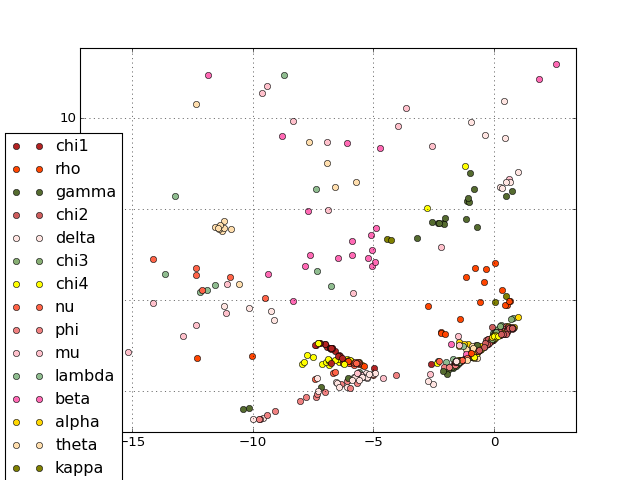

In [40]:
plot.figure()
clist = colors.cnames.values()

Y = Y_ae
legends = []
legend_handles = []
leg_check = dict()
plot.hold('on')

every=10
for idx in xrange(Y.shape[0]):
    if data_original[idx][1] is None:
        #plot.plot(Y[idx,0], Y[idx,1], 'kx')
        pass
    else:
        f, = plot.plot(Y[idx,0], Y[idx,1], 'o', color=clist[label_dict[data_original[idx][1]]])
        if data_original[idx][1] not in leg_check:
            legends.append(data_original[idx][1])
            legend_handles.append(f)
            leg_check[data_original[idx][1]] = True
        #if numpy.mod(idx, every) == 0:
        #    plot.annotate(xy=(Y[idx,0], Y[idx,1]), s=idx)

plot.hold('off')
plot.legend(legend_handles, legends, bbox_to_anchor=(0.1,0.8))
plot.grid('on')

plot.show()